# Data

## Data Understanding

Each record (row) in this dataset represents a home in for King County, which includes Seattle.

Each feature (column) in this dataset is some attribute of that home sale. You can view the file data/column_names.md in this repository for a full explanation of all variables in this dataset — 21 columns in total.

We are going to focus on the following features: **delete the ones we dont use from here!**

**price**: Sale price of the house in dollars

**id** - Unique identifier for a house

**date** - Date house was sold

**bedrooms** - Number of bedrooms

**bathrooms** - Number of bathrooms

**sqft_living** - Square footage of living space in the home

**sqft_lot** - Square footage of the lot

**floors** - Number of floors (levels) in house

**waterfront** - Whether the house is on a waterfront 
    Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts 

**view** - Quality of view from house
    Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other

**condition** - How good the overall condition of the house is. Related to maintenance of house.
    See the King County Assessor Website for further explanation of each condition code 

**grade** - Overall grade of the house. Related to the construction and design of the house.
    See the King County Assessor Website for further explanation of each building grade code
    
**sqft_above** - Square footage of house apart from basement

**sqft_basement** - Square footage of the basement
    
**yr_built** - Year when house was built
    
**yr_renovated** - Year when house was renovated
    
**zipcode** - ZIP Code used by the United States Postal Service
    
**lat** - Latitude coordinate
    
**long** - Longitude coordinate

**sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors

**sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

## Imports 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import statsmodels.api as sm
import folium
from folium.plugins import heat_map

from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import CooksDistance

Import the house data

In [3]:
df = pd.read_csv('./data/kc_house_data.csv', parse_dates = ['date'])

In [4]:
house = df.copy()

## Data Understanding

In [5]:
house.shape

(21597, 21)

In [6]:
house['date'].min(), house['date'].max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

In [7]:
house.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [8]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  float64       
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  object        
 9   view           21534 non-null  object        
 10  condition      21597 non-null  object        
 11  grade          21597 non-null  object        
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

## Data Cleaning

We drop the ID and date column as they are not of much use

- The house prices are only for a period of one year
- house ID are unique keys only

In [9]:
# Dropping the id and date column
house = house.drop(['id', 'date'], axis=1)

In [10]:
# splitting grade and keeping only the numerical value of the grade
house['grade'] = house['grade'].map(lambda x: x.split()[0])
house['grade'] = house['grade'].astype(int)

In [11]:
house['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [12]:
house['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [13]:
house['waterfront'].isnull().sum()

2376

Null values for waterfront feature accounts for ~10% of our data and ~99% of the remaining houses don't have waterfront view. We believe waterfront houses usually have higher prices and waterfront would be a key feature in the model. 

After further investigation, we find that the waterfront predictor is not classified well. Some houses classified as waterfront houses are located in front of a puddle which is should not affect the house prices grately. Also most houses which are waterfront are not classfied well. Please refer to [Blog explaining the waterfront predictor in this data](https://towardsdatascience.com/a-beginners-guide-to-feature-engineering-with-qgis-6147ffaba2eb)

We decided to drop the feature.

In [14]:
# dropping waterfront feature
house = house.drop(['waterfront'], axis=1)

In [15]:
# checking null values for view feature
house['view'].isnull().sum()

63

In [16]:
house['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

"View" feature has 63 null values which accounts for a very small percentage of the whole data set so we decide to drop the null values

In [17]:
# dropping 63 records with null view values
house = house.dropna(subset=['view'])

In [18]:
house['condition'].value_counts() # no null values

Average      13981
Good          5657
Very Good     1697
Fair           170
Poor            29
Name: condition, dtype: int64

In [19]:
house['yr_renovated'].value_counts()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [20]:
house['yr_renovated'].unique()

array([   0., 1991.,   nan, 2002., 2010., 1992., 2013., 1994., 1978.,
       2005., 2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990.,
       1988., 1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989.,
       2004., 1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971.,
       1979., 1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008.,
       1968., 2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955.,
       1982., 1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957.,
       1959., 1960., 1967., 1965., 1934., 1972., 1944., 1958.])

"yr renovated" feature - 
- with only 17704 non null values (82%)
- out of the non-null values, 16961 (96% of non-nulls) have "0" value. 
- Essentially , almost 79% of the values are not giving us any information. 

We decide to drop the "yr renovated" column.

In [21]:
# dropping yr renovated column 
house = house.drop(['yr_renovated'], axis=1)

In [22]:
house.info() #objects - View, condition and sqft_basement
# leave as string and change later using OHE - view, condition

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21534 non-null  float64
 1   bedrooms       21534 non-null  int64  
 2   bathrooms      21534 non-null  float64
 3   sqft_living    21534 non-null  int64  
 4   sqft_lot       21534 non-null  int64  
 5   floors         21534 non-null  float64
 6   view           21534 non-null  object 
 7   condition      21534 non-null  object 
 8   grade          21534 non-null  int64  
 9   sqft_above     21534 non-null  int64  
 10  sqft_basement  21534 non-null  object 
 11  yr_built       21534 non-null  int64  
 12  zipcode        21534 non-null  int64  
 13  lat            21534 non-null  float64
 14  long           21534 non-null  float64
 15  sqft_living15  21534 non-null  int64  
 16  sqft_lot15     21534 non-null  int64  
dtypes: float64(5), int64(9), object(3)
memory usage: 3

In [23]:
house['sqft_basement'].unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0', '620.0',
       '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0', '450.0',
       '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0', '1070.0',
       '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0', '210.0',
       '1430.0', '1950.0', '440.0', '220.0', '1160.0', '860.0', '580.0',
       '2060.0', '1820.0', '1180.0', '200.0', '1150.0', '1200.0', '680.0',
       '530.0', '1450.0', '1170.0', '1080.0', '960.0', '280.0', '870.0',
       '1100.0', '460.0', '1400.0', '660.0', '1220.0', '900.0', '420.0',
       '1580.0', '1380.0', '475.0', '690.0', '270.0', 

In [24]:
house.loc[house['sqft_basement'] == '?'] 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
6,257500.0,3,2.25,1715,6819,2.0,NONE,Average,7,1715,?,1995,98003,47.3097,-122.327,2238,6819
18,189000.0,2,1.00,1200,9850,1.0,NONE,Good,7,1200,?,1921,98002,47.3089,-122.210,1060,5095
42,861990.0,5,2.75,3595,5639,2.0,NONE,Average,9,3595,?,2014,98053,47.6848,-122.016,3625,5639
79,720000.0,4,2.50,3450,39683,2.0,NONE,Average,10,3450,?,2002,98010,47.3420,-122.025,3350,39750
112,272500.0,3,1.75,1540,12600,1.0,NONE,Good,7,1160,?,1980,98038,47.3624,-122.031,1540,11656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21442,504600.0,5,3.00,2360,5000,1.0,NONE,Average,7,1390,?,2008,98103,47.6931,-122.330,2180,5009
21447,337500.0,4,2.50,2330,4907,2.0,NONE,Average,7,2330,?,2013,98042,47.3590,-122.081,2300,3836
21473,352500.0,2,2.50,980,1010,3.0,NONE,Average,8,980,?,2008,98117,47.6844,-122.387,980,1023
21519,332000.0,4,2.50,2380,5737,2.0,NONE,Average,7,2380,?,2010,98023,47.2815,-122.356,2380,5396


For feature "sqft_basement" we notice "?" values for 452 entries. We decide to drop the feature itself as we feel sqft_above is better and cleaner feature. 

Note:
sqft_living = sqft_above + sqft_basement

In [25]:
house = house.drop(['sqft_basement'], axis=1)

In [26]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21534 non-null  float64
 1   bedrooms       21534 non-null  int64  
 2   bathrooms      21534 non-null  float64
 3   sqft_living    21534 non-null  int64  
 4   sqft_lot       21534 non-null  int64  
 5   floors         21534 non-null  float64
 6   view           21534 non-null  object 
 7   condition      21534 non-null  object 
 8   grade          21534 non-null  int64  
 9   sqft_above     21534 non-null  int64  
 10  yr_built       21534 non-null  int64  
 11  zipcode        21534 non-null  int64  
 12  lat            21534 non-null  float64
 13  long           21534 non-null  float64
 14  sqft_living15  21534 non-null  int64  
 15  sqft_lot15     21534 non-null  int64  
dtypes: float64(5), int64(9), object(2)
memory usage: 2.8+ MB


# Interpret a Correlation Heatmap to Build a Baseline Model

<AxesSubplot:title={'center':'Pearson Correlation of features'}>

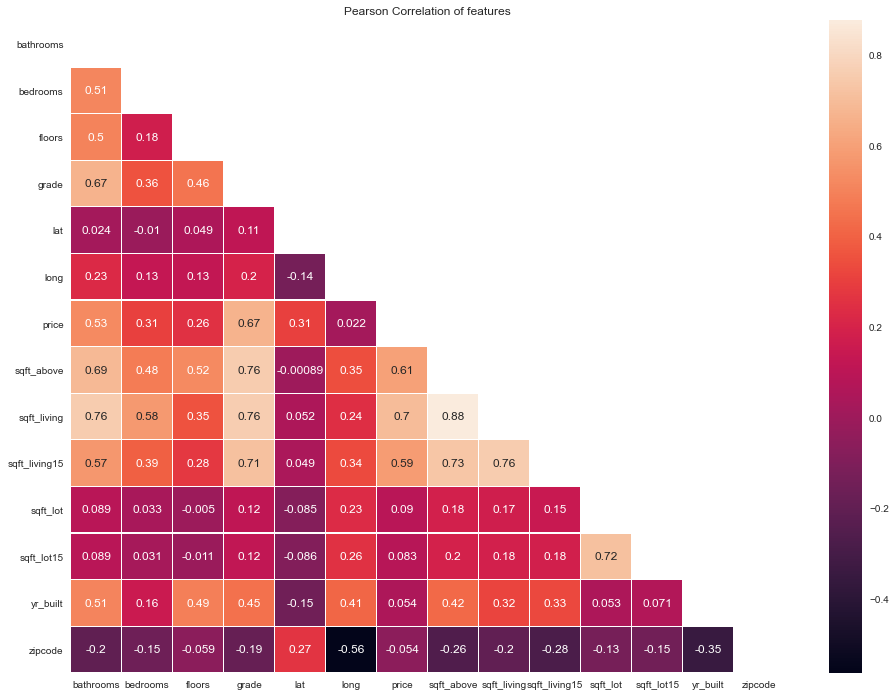

In [27]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in house.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = house.columns.difference(str_list) 
# Create Dataframe containing only numerical features
house_num = house[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(house_num.astype(float).corr(),linewidths=0.25, annot=True, mask=np.triu(np.ones_like(num_list, dtype=bool)))


Based on the plot above, 'sqft_living' is most strongly positively correlated (with the greatest magnitude) with the target (price).

In [28]:
# assign price to the variable target_feature

target_feature = 'price'

In [29]:
# assign sqft_living to the variable most_correlated_feature to make a simple regression model.

most_correlated_feature = 'sqft_living'

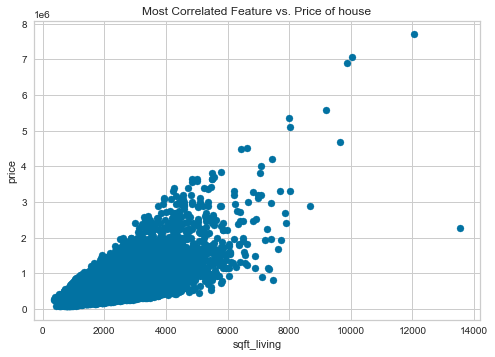

In [30]:
# plot a scatter plot to visulaize most correlated feature and target variable 
fig, ax = plt.subplots()

ax.scatter(x=house[most_correlated_feature], y=house[target_feature])
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel(target_feature)
ax.set_title("Most Correlated Feature vs. Price of house");

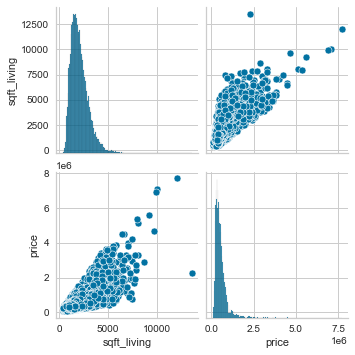

In [31]:
# see the distribution of the feature and target
slr_df = house[['sqft_living', 'price']]
sns.pairplot(slr_df);

We identified sqft_living as the most correlated feature, we have a scatter plot that shows a fairly clear linear relationship between that feature and the target.

However, linear regression works bbetter if the predictor and target are normally distributed.
Log-scaling can be a good tool to make right-skewed data more normal.

In [32]:
X = house['price']
y = house['sqft_living']
log_X = np.log(X)
log_y = np.log(y)

It looks like now we are ready to proceed with making our baseline model after the transformation.

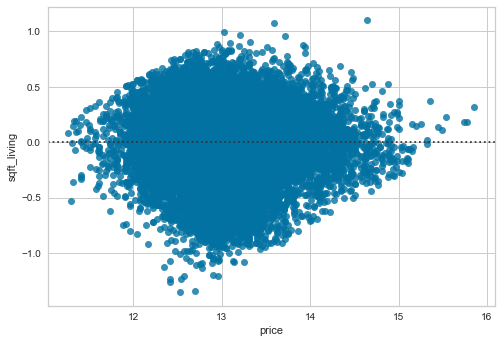

In [33]:
#residual plot to check for Heteroskedacity
sns.residplot(x=log_X, y=log_y);

In [34]:
endog = log_y
exog = sm.add_constant(log_X)
lin_reg_model = sm.OLS(endog, exog)
simple_model = lin_reg_model.fit().summary()

In [35]:
simple_model

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sqft_living   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.798e+04
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        07:35:36   Log-Likelihood:                -5550.0
No. Observations:               21534   AIC:                         1.110e+04
Df Residuals:                   21532   BIC:                         1.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4569      0.053      8.631      0.000       0.353       0.561
price          0.5437      0.004    134.090      0.000       0.536       0.552
==============================================================================
Omnibus:                      445.370   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              473.181
Skew:                          -0.363   Prob(JB):                    1.78e-103
Kurtosis:                       3.032   Cond. No.                         326.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Adding population data

In [36]:
popdf = pd.read_csv('./data/popdata.csv')

In [37]:
areadf = pd.read_csv('./data/KC_area.csv',header=1)

In [38]:
areadf.drop(areadf.columns[0],axis= 1,inplace=True)

In [39]:
king_pop = popdf[popdf["county"]=='King']

king_area = areadf[areadf["County"]=="King County"]

pd.concat([popdf, areadf], axis=1, join="inner")

,zip,city,county,pop,ZIP Code,City,County,Land Area (Sq. Meters),Land Area (Sq. Miles),Land Area (Sq. Kilometers)
0,99301,Pasco,Franklin,79819,98001,"Algona, Auburn, Federal Way, Lakeland North, L...",King County,"48,144,700",19,48
1,98052,Redmond,King,70245,98002,"Auburn, Pacific",King County,"18,530,000",7,19
2,98012,Bothell,Snohomish,67427,98003,"Federal Way, Lakeland South, Milton",King County,"30,089,500",12,30
3,98682,Vancouver,Clark,60887,98004,"Beaux Arts Village, Bellevue, Clyde Hill, Hunt...",King County,"18,200,300",7,18
4,98208,Everett,Snohomish,58162,98005,Bellevue,King County,"19,429,600",8,19
...,...,...,...,...,...,...,...,...,...,...
517,99124,Elmer City,Okanogan,271,99362,"College Place, Garrett, Walla Walla, Walla Wal...","Umatilla County, Walla Walla County","740,792,000",286,741
518,98621,Grays River,Wahkiakum,269,99363,Wallula,Walla Walla County,"115,344,000",45,115
519,98628,Klickitat,Klickitat,263,99371,Washtucna,"Adams County, Franklin County","527,778,000",204,528
520,99322,Bickleton,Klickitat,242,99402,Asotin,Asotin County,"741,921,000",286,742


In [40]:
king_pop = popdf[popdf["county"]=='King']

king_area = areadf[areadf["County"]=="King County"]

pd.concat([popdf, areadf], axis=1, join="inner")

,zip,city,county,pop,ZIP Code,City,County,Land Area (Sq. Meters),Land Area (Sq. Miles),Land Area (Sq. Kilometers)
0,99301,Pasco,Franklin,79819,98001,"Algona, Auburn, Federal Way, Lakeland North, L...",King County,"48,144,700",19,48
1,98052,Redmond,King,70245,98002,"Auburn, Pacific",King County,"18,530,000",7,19
2,98012,Bothell,Snohomish,67427,98003,"Federal Way, Lakeland South, Milton",King County,"30,089,500",12,30
3,98682,Vancouver,Clark,60887,98004,"Beaux Arts Village, Bellevue, Clyde Hill, Hunt...",King County,"18,200,300",7,18
4,98208,Everett,Snohomish,58162,98005,Bellevue,King County,"19,429,600",8,19
...,...,...,...,...,...,...,...,...,...,...
517,99124,Elmer City,Okanogan,271,99362,"College Place, Garrett, Walla Walla, Walla Wal...","Umatilla County, Walla Walla County","740,792,000",286,741
518,98621,Grays River,Wahkiakum,269,99363,Wallula,Walla Walla County,"115,344,000",45,115
519,98628,Klickitat,Klickitat,263,99371,Washtucna,"Adams County, Franklin County","527,778,000",204,528
520,99322,Bickleton,Klickitat,242,99402,Asotin,Asotin County,"741,921,000",286,742


In [41]:
king_data = pd.merge(
    king_area,
    king_pop,
    how="inner",
    on=None,
    left_on="ZIP Code",
    right_on='zip',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [42]:
king_data_compact =king_data.drop(columns=['City','County','Land Area (Sq. Miles)','Land Area (Sq. Kilometers)','zip'])

king_data_compact.head()

,ZIP Code,Land Area (Sq. Meters),city,county,pop
0,98001,"48,144,700",Auburn,King,33699
1,98002,"18,530,000",Auburn,King,33468
2,98003,"30,089,500",Federal Way,King,49533
3,98004,"18,200,300",Bellevue,King,36202
4,98005,"19,429,600",Bellevue,King,19223


In [43]:
def remove_chars(ds,char):
    """
    remove characters from the data series
    -
    ds: data series, lists. Element in data series or list must be a string.
    char: character to be removed. Accepts lists
    """
    for char in char:
        idx = 0
        for row in ds:
            if char in row:
                ds[idx] = row.replace(char,"")
            idx +=1
    return ds

In [44]:
remove_chars(king_data_compact["Land Area (Sq. Meters)"],',')

<ipython-input-43-968c3d56aa1e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[idx] = row.replace(char,"")


0      48144700
1      18530000
2      30089500
3      18200300
4      19429600
        ...    
73       183452
74     20167200
75     10815400
76    510454000
77    547876000
Name: Land Area (Sq. Meters), Length: 78, dtype: object

In [45]:
king_data_compact['Land Area (Sq. Meters)']= king_data_compact['Land Area (Sq. Meters)'].astype(int)

In [46]:
king_data_compact['density'] = king_data_compact['pop'] / king_data_compact['Land Area (Sq. Meters)']

In [47]:
merged_king_data = pd.merge(
    house,
    king_data_compact,
    how="inner",
    on=None,
    left_on="zipcode",
    right_on='ZIP Code',
    left_index=False,
    right_index=False,
    sort=True,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

In [48]:
merged_king_data['zipcode']== merged_king_data["ZIP Code"]

0        True
1        True
2        True
3        True
4        True
         ... 
20223    True
20224    True
20225    True
20226    True
20227    True
Length: 20228, dtype: bool

In [49]:
merged_king_data.drop(columns=['zipcode','county'], inplace=True)

merged_king_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20228 entries, 0 to 20227
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   20228 non-null  float64
 1   bedrooms                20228 non-null  int64  
 2   bathrooms               20228 non-null  float64
 3   sqft_living             20228 non-null  int64  
 4   sqft_lot                20228 non-null  int64  
 5   floors                  20228 non-null  float64
 6   view                    20228 non-null  object 
 7   condition               20228 non-null  object 
 8   grade                   20228 non-null  int64  
 9   sqft_above              20228 non-null  int64  
 10  yr_built                20228 non-null  int64  
 11  lat                     20228 non-null  float64
 12  long                    20228 non-null  float64
 13  sqft_living15           20228 non-null  int64  
 14  sqft_lot15              20228 non-null

In [50]:
merged_king_data['grade']= merged_king_data['grade'].astype(object)
map_df=merged_king_data.copy()

merged_king_data.drop(columns=['density','pop','Land Area (Sq. Meters)','ZIP Code','lat','long'],inplace=True)

merged_king_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20228 entries, 0 to 20227
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20228 non-null  float64
 1   bedrooms       20228 non-null  int64  
 2   bathrooms      20228 non-null  float64
 3   sqft_living    20228 non-null  int64  
 4   sqft_lot       20228 non-null  int64  
 5   floors         20228 non-null  float64
 6   view           20228 non-null  object 
 7   condition      20228 non-null  object 
 8   grade          20228 non-null  object 
 9   sqft_above     20228 non-null  int64  
 10  yr_built       20228 non-null  int64  
 11  sqft_living15  20228 non-null  int64  
 12  sqft_lot15     20228 non-null  int64  
 13  city           20228 non-null  object 
dtypes: float64(3), int64(7), object(4)
memory usage: 2.3+ MB


In [51]:
map_df = map_df[['price', 'lat', 'long', 'city']]

In [52]:
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20228 entries, 0 to 20227
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   20228 non-null  float64
 1   lat     20228 non-null  float64
 2   long    20228 non-null  float64
 3   city    20228 non-null  object 
dtypes: float64(3), object(1)
memory usage: 790.2+ KB


In [53]:
merged_king_data['price'] = np.log(merged_king_data['price'])

In [54]:
merged_king_data['bathrooms_per_bedroom'] = merged_king_data['bathrooms'] / merged_king_data['bedrooms']
merged_king_data.drop(columns=['bathrooms', 'bedrooms'], axis=1)

,price,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,city,bathrooms_per_bedroom
0,12.388394,1220,8075,1.0,NONE,Fair,7,890,1969,1290,7800,Auburn,0.250000
1,12.567237,2240,4648,2.0,NONE,Average,7,2240,2005,2221,4557,Auburn,0.625000
2,13.049793,2714,17936,2.0,NONE,Average,9,2714,2005,2590,18386,Auburn,0.833333
3,12.793859,2160,9528,2.0,NONE,Average,9,2160,1992,2280,9937,Auburn,0.625000
4,12.345835,1450,11204,1.0,NONE,Average,7,1450,2003,1520,9518,Auburn,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20223,13.253392,1550,1280,2.0,NONE,Average,9,1220,2013,1550,1579,Seattle,1.083333
20224,13.919871,3660,4760,2.0,NONE,Average,9,2840,2014,3210,4640,Seattle,0.875000
20225,13.825461,3610,4000,2.0,NONE,Average,9,2640,2007,1980,4000,Seattle,0.812500
20226,13.023647,1510,1618,2.5,NONE,Average,8,1330,2011,1350,1397,Seattle,0.833333


In [55]:
X = merged_king_data.drop(columns='price')
y = merged_king_data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

cat_cols = [c for c in merged_king_data if merged_king_data[c].dtype == 'O']
cat_cols

X_train.describe(include=['O'])

,view,condition,grade,city
count,15171,15171,15171,15171
unique,5,5,10,22
top,NONE,Average,7,Seattle
freq,13647,9852,6319,6750


In [56]:
# Import our One Hot Encoder
from sklearn.preprocessing import OneHotEncoder
# Going to use ColumnTransformer to encode only cat cols
from sklearn.compose import ColumnTransformer

In [57]:
encoder = OneHotEncoder(handle_unknown='error',
                        drop='first', 
                        categories='auto')

ct = ColumnTransformer(transformers=[('ohe', encoder, cat_cols)],
                       remainder='passthrough')

ct.fit(X_train)
X_train_enc = ct.transform(X_train)
X_test_enc = ct.transform(X_test)

In [58]:
X_train_enc.todense()

matrix([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.42000000e+03, 2.32740000e+04, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.44000000e+03, 5.10200000e+03, 3.33333333e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.23000000e+03, 1.19000000e+04, 5.83333333e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.02000000e+03, 7.30000000e+03, 8.33333333e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         3.45000000e+03, 3.39450000e+04, 7.00000000e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.40500000e+03, 3.00000000e+03, 1.00000000e+00]])

In [59]:
len(y_train)

15171

In [60]:
X_train_enc = pd.DataFrame(X_train_enc.todense(), columns= ct.get_feature_names(), index = X_train.index)
X_train_enc


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_5,ohe__x2_6,...,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,bathrooms_per_bedroom
5900,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,2.50,3340.0,24755.0,2.0,3340.0,2002.0,3420.0,23274.0,0.500000
20195,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.00,1650.0,5102.0,1.0,1300.0,1953.0,1440.0,5102.0,0.333333
991,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.75,2230.0,13529.0,1.0,2230.0,1949.0,2230.0,11900.0,0.583333
2447,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.0,1.75,1640.0,7194.0,1.5,1480.0,1915.0,1440.0,9405.0,0.437500
1887,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.00,1420.0,11040.0,1.0,1420.0,1961.0,1530.0,8208.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,4.0,1.75,1800.0,4180.0,2.0,1800.0,1921.0,2180.0,4620.0,0.437500
11964,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.00,820.0,681.0,3.0,820.0,2006.0,820.0,1156.0,0.500000
5390,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.50,2390.0,6435.0,1.0,1600.0,1978.0,2020.0,7300.0,0.833333
860,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,3.50,4220.0,26784.0,1.0,2110.0,1958.0,3450.0,33945.0,0.700000


In [61]:
X_test_enc = pd.DataFrame(X_test_enc.todense(), columns= ct.get_feature_names(), index = X_test.index)
X_test_enc

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x0_NONE,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_5,ohe__x2_6,...,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,sqft_living15,sqft_lot15,bathrooms_per_bedroom
15378,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.50,1500.0,1375.0,2.0,1200.0,2014.0,1680.0,1627.0,0.833333
12124,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,7.0,2.75,3110.0,4400.0,1.5,2010.0,1914.0,1240.0,4280.0,0.392857
13734,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.50,1460.0,5700.0,1.5,1460.0,1912.0,1780.0,3800.0,0.750000
2043,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,2.00,1460.0,7860.0,1.0,1460.0,1967.0,1850.0,8148.0,0.666667
16675,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,1.00,1020.0,10200.0,1.0,1020.0,1954.0,1170.0,8188.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,2.00,1690.0,10062.0,1.0,940.0,1928.0,2390.0,6650.0,0.666667
17665,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.50,1460.0,1296.0,2.0,1160.0,2008.0,1460.0,1296.0,1.250000
17892,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,1.00,1210.0,10185.0,1.0,1210.0,1957.0,1320.0,10245.0,0.333333
12802,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.50,1780.0,2493.0,3.0,1780.0,1981.0,2050.0,4400.0,1.250000


In [62]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15171 entries, 5900 to 15795
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ohe__x0_EXCELLENT      15171 non-null  float64
 1   ohe__x0_FAIR           15171 non-null  float64
 2   ohe__x0_GOOD           15171 non-null  float64
 3   ohe__x0_NONE           15171 non-null  float64
 4   ohe__x1_Fair           15171 non-null  float64
 5   ohe__x1_Good           15171 non-null  float64
 6   ohe__x1_Poor           15171 non-null  float64
 7   ohe__x1_Very Good      15171 non-null  float64
 8   ohe__x2_5              15171 non-null  float64
 9   ohe__x2_6              15171 non-null  float64
 10  ohe__x2_7              15171 non-null  float64
 11  ohe__x2_8              15171 non-null  float64
 12  ohe__x2_9              15171 non-null  float64
 13  ohe__x2_10             15171 non-null  float64
 14  ohe__x2_11             15171 non-null  float64
 15 

## Start building models 

## Dummy Model 

In [63]:
# Instantiate
dummy_lr = DummyRegressor()

In [64]:
dummy_lr.fit(X,y)

DummyRegressor()

In [65]:
# score
dummy_lr.score(X,y)

0.0

In [66]:
y_train.head()

5900     13.457406
20195    13.407542
991      14.187074
2447     13.049793
1887     13.102161
Name: price, dtype: float64

In [67]:
# Let's create a full train_df to evaluate our options
# This isn't totally necessary, just will let us visualize later
# You can use this if you prefer the ols method instead of OLS or sklearn
train_df = pd.concat([X_train_enc, y_train], axis=1)

test_df = pd.concat([X_test_enc, y_test], axis=1)

In [68]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15171 entries, 5900 to 15795
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ohe__x0_EXCELLENT      15171 non-null  float64
 1   ohe__x0_FAIR           15171 non-null  float64
 2   ohe__x0_GOOD           15171 non-null  float64
 3   ohe__x0_NONE           15171 non-null  float64
 4   ohe__x1_Fair           15171 non-null  float64
 5   ohe__x1_Good           15171 non-null  float64
 6   ohe__x1_Poor           15171 non-null  float64
 7   ohe__x1_Very Good      15171 non-null  float64
 8   ohe__x2_5              15171 non-null  float64
 9   ohe__x2_6              15171 non-null  float64
 10  ohe__x2_7              15171 non-null  float64
 11  ohe__x2_8              15171 non-null  float64
 12  ohe__x2_9              15171 non-null  float64
 13  ohe__x2_10             15171 non-null  float64
 14  ohe__x2_11             15171 non-null  float64
 15 

In [69]:
# Code to evaluate our options
train_df.corr()['price']

ohe__x0_EXCELLENT        0.230262
ohe__x0_FAIR             0.093622
ohe__x0_GOOD             0.179544
ohe__x0_NONE            -0.335403
ohe__x1_Fair            -0.081820
ohe__x1_Good            -0.036274
ohe__x1_Poor            -0.032465
ohe__x1_Very Good        0.062928
ohe__x2_5               -0.151208
ohe__x2_6               -0.312156
ohe__x2_7               -0.333979
ohe__x2_8                0.106689
ohe__x2_9                0.313598
ohe__x2_10               0.339292
ohe__x2_11               0.271041
ohe__x2_12               0.186727
ohe__x2_13               0.093900
ohe__x3_Bellevue         0.273851
ohe__x3_Black Diamond   -0.034509
ohe__x3_Bothell          0.001914
ohe__x3_Carnation       -0.025036
ohe__x3_Duvall          -0.024870
ohe__x3_Fall City        0.004646
ohe__x3_Federal Way     -0.207417
ohe__x3_Issaquah         0.073911
ohe__x3_Kenmore         -0.012117
ohe__x3_Kent            -0.209770
ohe__x3_Kirkland         0.084781
ohe__x3_Maple Valley    -0.095183
ohe__x3_Medina

In [70]:
keep_cols = ['sqft_living']

In [71]:
X_train1 = X_train_enc[keep_cols]

In [72]:
simple_mdl = LinearRegression()

In [73]:
simple_mdl.fit(X_train1, y_train)

LinearRegression()

In [74]:
simple_mdl.score(X_train1, y_train)

0.48531659872055244

In [75]:
def summary_model(model, X, y):
#     rsq = r2_score(X, y)
#     adj_rsq = (1-rsq)*((len(X)-1)/(len(X)-len(X[0])-1))
# \n Adjusted R-squared: {adj_rsq}
    result = (
        print(f'R-squared: {model.score(X,y)} \nIntercept: {model.intercept_} \nCoefficient: {model.coef_}')
    )
    return result

In [76]:
summary_model(simple_mdl, X_train1, y_train)

R-squared: 0.48531659872055244 
Intercept: 12.238264780229283 
Coefficient: [0.00039715]


### Multiple Model 1

In [77]:
# Need to prep our data... can do that all with sklearn!
# # Time to scale!
# # Import our scaler
# from sklearn.preprocessing import StandardScaler

# # Instantiate our scaler
# scaler = StandardScaler()

# # Fit our scaler    
# cont_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'yr_built', 'sqft_living15', 'sqft_lot15']
# scaler.fit(X_train_enc[cont_cols])

# #copy df
# X_train_final = X_train_enc.copy()
# X_test_final = X_test_enc.copy()
# # Transform training data
# X_train_scaled = scaler.transform(X_train_enc[cont_cols])
# # X_train_final[:] = X_train_scaled
# # Transform testing data
# X_test_scaled = scaler.transform(X_test_enc[cont_cols])
# # X_test_final[:] = X_test_scaled

In [78]:
# X_train_scaled

In [79]:
model1 = LinearRegression()

model1.fit(X_train_enc, y_train)

LinearRegression()

In [80]:
summary_model(model1, X_train_enc, y_train)

R-squared: 0.7771772714063174 
Intercept: 19.330270264836535 
Coefficient: [ 2.81170551e-01  2.32310905e-02  4.25096927e-02 -7.06266006e-02
 -1.61819015e-01  3.89170158e-02 -1.65218209e-01  1.03797914e-01
  3.69280706e-02  1.72673090e-01  4.20621261e-01  5.81169542e-01
  7.40989866e-01  8.22317039e-01  8.77136472e-01  8.67542050e-01
  9.26501921e-01  6.76742934e-01  2.78480938e-01  4.00285402e-01
  3.49178740e-01  3.36323511e-01  4.30018386e-01 -3.64363315e-02
  4.78083945e-01  3.80777007e-01  4.81211840e-02  6.07359607e-01
  1.69306246e-01  1.13815485e+00  7.70720750e-01  3.41976458e-01
  5.68948099e-01  2.27656229e-01  4.78266585e-01  4.81925998e-01
  3.83118529e-01  4.07633726e-01 -2.67900286e-02  7.90315370e-02
  1.45885141e-04  5.21266954e-07  8.74017831e-02  1.22144142e-05
 -3.98688184e-03  9.04335993e-05 -4.64936879e-07 -1.38893168e-02]


In [81]:
# VIF dataframe
def cal_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

In [82]:
cal_vif(X_train_enc)

,feature,VIF
0,ohe__x0_EXCELLENT,1.396048
1,ohe__x0_FAIR,1.392610
2,ohe__x0_GOOD,1.571619
3,ohe__x0_NONE,23.186880
4,ohe__x1_Fair,1.031386
5,ohe__x1_Good,1.617366
6,ohe__x1_Poor,1.024387
7,ohe__x1_Very Good,1.205906
8,ohe__x2_5,8.648986
9,ohe__x2_6,64.062391


Model 2

In [83]:
X_train_enc.columns

Index(['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_7', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
       'yr_built', 'sqft_living15', 'sqft_lot15', 'bathrooms_per_bedroom'],
      dtype='object')

In [84]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD', 'ohe__x0_NONE',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_living15', 'sqft_lot15']

X_train2 = X_train_enc[keep_cols]
model2 = LinearRegression()

model2.fit(X_train2, y_train)

LinearRegression()

In [85]:
summary_model(model2, X_train2, y_train)

R-squared: 0.7558063044949184 
Intercept: 11.924409420622904 
Coefficient: [ 2.82090551e-01  7.94845048e-03  3.92745147e-02 -9.49813393e-02
 -1.32712843e-01  8.76785999e-02 -1.03509689e-01  1.84505379e-01
 -2.90945753e-01 -2.00683191e-01  1.31963832e-01  2.67874342e-01
  3.44558806e-01  3.84429379e-01  3.53031522e-01  4.79408324e-01
  7.03942414e-01  2.59322399e-01  4.15211280e-01  3.37332937e-01
  3.25160363e-01  4.53788627e-01 -3.03824176e-02  4.81938780e-01
  3.99488806e-01  3.31556649e-02  6.23615015e-01  1.44592457e-01
  1.19529801e+00  8.07525892e-01  3.33538566e-01  5.62529200e-01
  2.24301008e-01  4.81775584e-01  5.78184020e-01  3.57371465e-01
  4.18312695e-01 -1.26090454e-02  2.40229034e-02  1.66607346e-04
  6.37127487e-07  4.19915793e-02  1.91725920e-05  9.74313615e-05
 -5.43779546e-07]


In [86]:
cal_vif(X_train2)

,feature,VIF
0,ohe__x0_EXCELLENT,1.329796
1,ohe__x0_FAIR,1.309050
2,ohe__x0_GOOD,1.467613
3,ohe__x0_NONE,16.770449
4,ohe__x1_Fair,1.029151
5,ohe__x1_Good,1.580208
6,ohe__x1_Poor,1.024096
7,ohe__x1_Very Good,1.196842
8,ohe__x2_5,1.069231
9,ohe__x2_6,1.312240


Model 3

In [87]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Poor', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City',
       'ohe__x3_Federal Way', 'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon', 'sqft_living', 'sqft_lot', 'bathrooms_per_bedroom']
X_train3 = X_train_enc[keep_cols]
X_test3= X_test_enc[keep_cols]
model3 = LinearRegression()

model3.fit(X_train3, y_train)

LinearRegression()

In [88]:
# X_new = SelectKBest(f_re, k=20).fit_transform(X, y)
X_new = feature_selection.f_regression(X=X_train3, y=y_train)
X_new

(array([8.49296340e+02, 1.34133516e+02, 5.05276696e+02, 1.02233624e+02,
        1.99859453e+01, 1.60045849e+01, 6.03074897e+01, 3.54938399e+02,
        1.63766477e+03, 1.74648184e+02, 1.65448384e+03, 1.97341934e+03,
        1.20272028e+03, 5.48002449e+02, 1.34937672e+02, 1.22981888e+03,
        1.80861175e+01, 5.55781807e-02, 9.51378844e+00, 9.38826019e+00,
        3.27487276e-01, 6.81933461e+02, 8.33213238e+01, 2.22747542e+00,
        6.98212448e+02, 1.09820217e+02, 1.38684125e+02, 2.11385111e+02,
        5.42942513e+02, 1.24822019e+01, 2.20957174e+02, 2.60944855e+02,
        3.56857626e+02, 2.85070449e+00, 3.83708657e+00, 5.29493609e-02,
        1.43034873e+04, 1.81716347e+02, 1.49082437e+03]),
 array([1.00974565e-181, 6.88965976e-031, 4.21466898e-110, 5.87721587e-024,
        7.85790880e-006, 6.34891819e-005, 8.63064725e-015, 2.78400100e-078,
        0.00000000e+000, 1.18351336e-039, 0.00000000e+000, 0.00000000e+000,
        1.11613565e-253, 4.37833336e-119, 4.61152792e-031, 3.94142

In [89]:
feature_selection.SelectKBest(X_new)

SelectKBest(score_func=(array([8.49296340e+02, 1.34133516e+02, 5.05276696e+02, 1.02233624e+02,
       1.99859453e+01, 1.60045849e+01, 6.03074897e+01, 3.54938399e+02,
       1.63766477e+03, 1.74648184e+02, 1.65448384e+03, 1.97341934e+03,
       1.20272028e+03, 5.48002449e+02, 1.34937672e+02, 1.22981888e+03,
       1.80861175e+01, 5.55781807e-02, 9.51378844e+00, 9.38826019e+00,
       3.27487276e-01, 6.81...
       2.12399734e-005, 8.13629657e-001, 2.04300295e-003, 2.18762469e-003,
       5.67150911e-001, 4.42606556e-147, 7.83781371e-020, 1.35596008e-001,
       1.81974379e-150, 1.31232926e-025, 7.10844831e-032, 1.43075075e-047,
       5.05659192e-118, 4.12068781e-004, 1.24976099e-049, 3.26675812e-058,
       1.08725305e-078, 9.13544612e-002, 5.01488518e-002, 8.18011510e-001,
       0.00000000e+000, 3.52971693e-041, 3.49939746e-311])))

In [90]:
print(model3)

LinearRegression()


In [91]:
summary_model(model3, X_train3, y_train)

R-squared: 0.7472009033402027 
Intercept: 11.95157909509602 
Coefficient: [ 3.76569788e-01  1.07913676e-01  1.38485476e-01 -1.37999526e-01
  7.75638072e-02 -8.49743313e-02  1.71966849e-01 -3.05249134e-01
 -2.14394932e-01  1.67442931e-01  3.40485051e-01  4.36105692e-01
  5.02631136e-01  4.79557502e-01  5.45782101e-01  7.15961701e-01
  2.60564279e-01  4.33429777e-01  3.24109386e-01  3.45691767e-01
  4.60377063e-01 -3.05271620e-02  4.97187205e-01  4.09466791e-01
  4.32160640e-02  6.27766199e-01  1.71902458e-01  1.21490837e+00
  8.34759752e-01  3.39806785e-01  5.80603862e-01  2.35466980e-01
  5.15628568e-01  5.70022659e-01  4.13359370e-01  4.07875135e-01
  2.17015368e-04  3.23642355e-07  7.48150528e-02]


In [92]:
X_train3

,ohe__x0_EXCELLENT,ohe__x0_FAIR,ohe__x0_GOOD,ohe__x1_Fair,ohe__x1_Good,ohe__x1_Poor,ohe__x1_Very Good,ohe__x2_5,ohe__x2_6,ohe__x2_8,...,ohe__x3_North Bend,ohe__x3_Redmond,ohe__x3_Renton,ohe__x3_Sammamish,ohe__x3_Seattle,ohe__x3_Snoqualmie,ohe__x3_Vashon,sqft_living,sqft_lot,bathrooms_per_bedroom
5900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3340.0,24755.0,0.500000
20195,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1650.0,5102.0,0.333333
991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2230.0,13529.0,0.583333
2447,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1640.0,7194.0,0.437500
1887,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1420.0,11040.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1800.0,4180.0,0.437500
11964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,820.0,681.0,0.500000
5390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2390.0,6435.0,0.833333
860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4220.0,26784.0,0.700000


In [93]:
cal_vif(X_train3)

,feature,VIF
0,ohe__x0_EXCELLENT,1.088877
1,ohe__x0_FAIR,1.037608
2,ohe__x0_GOOD,1.087106
3,ohe__x1_Fair,1.027826
4,ohe__x1_Good,1.520616
5,ohe__x1_Poor,1.023146
6,ohe__x1_Very Good,1.174690
7,ohe__x2_5,1.062997
8,ohe__x2_6,1.273552
9,ohe__x2_8,2.056109


Look at errors for Model 3

In [94]:
np.exp(y_train.max())

7700000.000000004

In [113]:
# Grab training set predictions
train_preds = model3.predict(X_train3)

# And test preds
test_preds = model3.predict(X_test3)

In [114]:
print("Training Metrics:")
# R2
print(f"R2: {r2_score(y_train, train_preds):.3f}")
# MAE
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
# MSE
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error in $: {mean_squared_error(np.exp(y_train), np.exp(train_preds), squared=False)}")

Training Metrics:
R2: 0.747
Mean Absolute Error: 0.199
Mean Squared Error: 0.070
Root Mean Squared Error: 0.265
Root Mean Squared Error in $: 218399.67286177684


In [115]:
print("Testing Metrics:")
# R2
print(f"R2: {r2_score(y_test, test_preds):.3f}")
# MAE
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
# MSE
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error in $: {mean_squared_error(np.exp(y_test), np.exp(test_preds), squared=False)}")

Testing Metrics:
R2: 0.756
Mean Absolute Error: 0.197
Mean Squared Error: 0.069
Root Mean Squared Error: 0.263
Root Mean Squared Error in $: 177010.0879295771


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


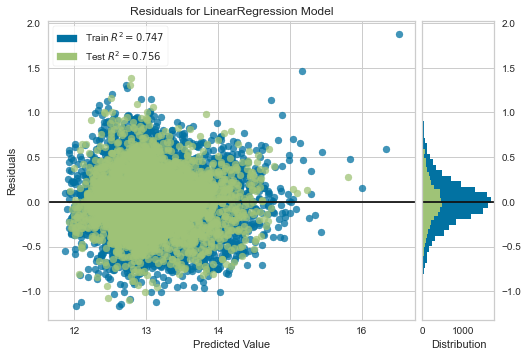

In [98]:


visualizer = ResidualsPlot(model3)

visualizer.fit(X_train3, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test3, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [99]:
# sns.residplot(x=X_train3, y=y_train);

Autocorrelation

In [100]:
resids = train_preds - y_train

In [101]:
sm.stats.stattools.durbin_watson(resids) # YAyyyy

1.9916600157251698

Deal with Leverage/outliers

In [102]:
# # Instantiate and fit the visualizer
# visualizer = CooksDistance()
# visualizer.fit(X_train3, y_train)
# visualizer.show();

Statsmodel model 3

In [103]:
X_train3.shape

(15171, 39)

In [104]:
y_sm = pd.DataFrame(y_train)

In [105]:
y_sm.shape

(15171, 1)

In [106]:
endog = y_train
exog = X_train3
lin_reg_model = sm.OLS(endog=endog, exog=sm.add_constant(exog)).fit()

In [107]:
# model4 = lin_reg_model.fit()

In [108]:
lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     1147.
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        07:35:50   Log-Likelihood:                -1371.8
No. Observations:               15171   AIC:                             2824.
Df Residuals:                   15131   BIC:                             3129.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    11.9516      0.016    730.987      0.000      11.920      11.984
ohe__x0_EXCELLENT         0.3766      0.018     20.865      0.000       0.341       0.412
ohe__x0_FAIR              0.1079      0.017      6.389      0.000       0.075       0.141
ohe__x0_GOOD              0.1385      0.014      9.571      0.000       0.110       0.167
ohe__x1_Fair             -0.1380      0.025     -5.550      0.000      -0.187      -0.089
ohe__x1_Good              0.0776      0.005     14.737      0.000       0.067       0.088
ohe__x1_Poor             -0.0850      0.056     -1.519      0.129      -0.195       0.025
ohe__x1_Very Good         0.1720      0.008     20.863      0.000       0.156       0.188
ohe__x2_5                -0.3052      0.021    -14.748      0.000      -0.346      -0.265
ohe__x2_6                -0.2144      0.008    -26.524      0.000      -0.230      -0.199
ohe__x2_8                 0.1674      0.006     28.612      0.000       0.156       0.179
ohe__x2_9                 0.3405      0.009     38.775      0.000       0.323       0.358
ohe__x2_10                0.4361      0.013     34.249      0.000       0.411       0.461
ohe__x2_11                0.5026      0.020     24.765      0.000       0.463       0.542
ohe__x2_12                0.4796      0.037     12.842      0.000       0.406       0.553
ohe__x2_13                0.5458      0.092      5.946      0.000       0.366       0.726
ohe__x3_Bellevue          0.7160      0.016     45.683      0.000       0.685       0.747
ohe__x3_Black Diamond     0.2606      0.034      7.722      0.000       0.194       0.327
ohe__x3_Bothell           0.4334      0.026     16.939      0.000       0.383       0.484
ohe__x3_Carnation         0.3241      0.031     10.415      0.000       0.263       0.385
ohe__x3_Duvall            0.3457      0.026     13.079      0.000       0.294       0.397
ohe__x3_Fall City         0.4604      0.037     12.474      0.000       0.388       0.533
ohe__x3_Federal Way      -0.0305      0.017     -1.795      0.073      -0.064       0.003
ohe__x3_Issaquah          0.4972      0.017     28.419      0.000       0.463       0.531
ohe__x3_Kenmore           0.4095      0.023     18.045      0.000       0.365       0.454
ohe__x3_Kent              0.0432      0.016      2.648      0.008       0.011       0.075
ohe__x3_Kirkland          0.6278      0.016     38.455      0.000       0.596       0.660
ohe__x3_Maple Valley      0.1719      0.018      9.377      0.000       0.136       0.208
ohe__x3_Medina            1.2149      0.049     24.694      0.000       1.118       1.311
ohe__x3_Mercer Island     0.8348      0.023     35.867      0.000       0.789       0.880
ohe__x3_North Bend        0.3398      0.024     14.053      0.000       0.292       0.387
ohe__x3_Redmond        

### Visualizations

In [109]:
# m = folium.Map(location=[45.5236, -122.6750])

Model 5 - dropping features which have p-value > 0.05 (alpha)
- ohe__x1_Poor
- ohe__x3_Federal Way

In [111]:
keep_cols = ['ohe__x0_EXCELLENT', 'ohe__x0_FAIR', 'ohe__x0_GOOD',
       'ohe__x1_Fair', 'ohe__x1_Good', 'ohe__x1_Very Good',
       'ohe__x2_5', 'ohe__x2_6', 'ohe__x2_8', 'ohe__x2_9',
       'ohe__x2_10', 'ohe__x2_11', 'ohe__x2_12', 'ohe__x2_13',
       'ohe__x3_Bellevue', 'ohe__x3_Black Diamond', 'ohe__x3_Bothell',
       'ohe__x3_Carnation', 'ohe__x3_Duvall', 'ohe__x3_Fall City', 
        'ohe__x3_Issaquah', 'ohe__x3_Kenmore',
       'ohe__x3_Kent', 'ohe__x3_Kirkland', 'ohe__x3_Maple Valley',
       'ohe__x3_Medina', 'ohe__x3_Mercer Island', 'ohe__x3_North Bend',
       'ohe__x3_Redmond', 'ohe__x3_Renton', 'ohe__x3_Sammamish',
       'ohe__x3_Seattle', 'ohe__x3_Snoqualmie', 'ohe__x3_Vashon', 'sqft_living', 
        'sqft_lot', 'bathrooms_per_bedroom']
X_train5 = X_train_enc[keep_cols]
X_test5=X_test_enc[keep_cols]
model5= LinearRegression()

model5.fit(X_train5, y_train)

LinearRegression()

In [112]:
summary_model(model5, X_train5, y_train)

R-squared: 0.7471079082288917 
Intercept: 11.933217730869448 
Coefficient: [ 3.75910771e-01  1.07132111e-01  1.38379085e-01 -1.37851106e-01
  7.77798954e-02  1.72651472e-01 -3.07705729e-01 -2.14578479e-01
  1.66853994e-01  3.40170413e-01  4.35445616e-01  5.01969858e-01
  4.79161682e-01  5.45146802e-01  7.33714038e-01  2.78532173e-01
  4.50816245e-01  3.42204618e-01  3.63741485e-01  4.78492218e-01
  5.15270692e-01  4.27462324e-01  6.11398477e-02  6.45587779e-01
  1.89872167e-01  1.23288341e+00  8.52786432e-01  3.57902257e-01
  5.98532371e-01  2.53399800e-01  5.33748878e-01  5.87806562e-01
  4.31056237e-01  4.26035738e-01  2.17116254e-04  3.22684701e-07
  7.54123793e-02]


In [117]:
# Grab training set predictions
train_preds = model5.predict(X_train5)

# And test preds
test_preds = model5.predict(X_test5)

In [118]:
print("Training Metrics:")
# R2
print(f"R2: {r2_score(y_train, train_preds):.3f}")
# MAE
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
# MSE
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error in $: {mean_squared_error(np.exp(y_train), np.exp(train_preds), squared=False)}")

Training Metrics:
R2: 0.747
Mean Absolute Error: 0.199
Mean Squared Error: 0.070
Root Mean Squared Error: 0.265
Root Mean Squared Error in $: 218427.1462831996


In [119]:
print("Testing Metrics:")
# R2
print(f"R2: {r2_score(y_test, test_preds):.3f}")
# MAE
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
# MSE
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")
# RMSE - just MSE but set squared=False
print(f"Root Mean Squared Error in $: {mean_squared_error(np.exp(y_test), np.exp(test_preds), squared=False)}")

Testing Metrics:
R2: 0.756
Mean Absolute Error: 0.197
Mean Squared Error: 0.069
Root Mean Squared Error: 0.263
Root Mean Squared Error in $: 177056.22884122326


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


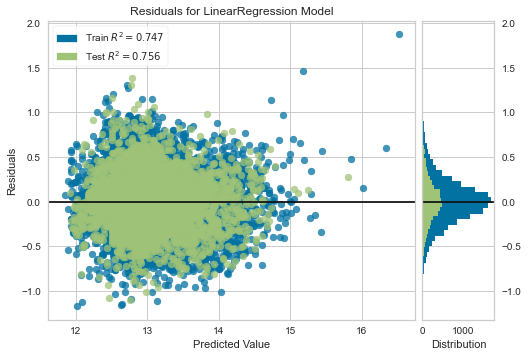

In [121]:


visualizer = ResidualsPlot(model5)

visualizer.fit(X_train5, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test5, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()